In [3]:
import numpy as np  # linear algebra
import pandas as pd  #

import vtreat #vtreat for preprocessing

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import time
import datetime
import os

import matplotlib.pyplot as plt
#Warning Disable
import warnings
warnings.filterwarnings("ignore")

/Users/huybui/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
!ls

HousePricesMain.ipynb main.ipynb            train.csv
Submission            sample_submission.csv
data_description.txt  test.csv


# Baseline model with v_treat and XG_Boost


In [5]:
#The scoring function for my baseline model
def log_rmse_cv(estimator, x, y):
    yPred = estimator.predict(x)
    log_y = np.log(y)
    log_yPred = np.log(yPred)
    score=np.sqrt(np.sum(np.square(log_y-log_yPred))/len(y))
    return score

In [6]:
#Data 
df=pd.read_csv("train.csv")
df.head()
X=df.drop(['SalePrice','Id'],axis=1)
y=df['SalePrice']

X_train, X_test, y_train , y_test = train_test_split(X,y,random_state=10)

X_train=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)

X_test=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

In [322]:
#Processing train set and test set
start = time.time() #Check the time

plan = vtreat.NumericOutcomeTreatment()
X_new = plan.fit_transform(X,y) #We use X and y here
X_new=X_new.values.astype('f4') #Convert 0 to floats to avoid sparse matrix

X_test_new=plan.transform(X_test)
X_test_new=X_test_new.values.astype('f4')

end = time.time()
print(end - start)

15.253493070602417


Another good way to convert sparse matrix to dense one [here](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.preprocessing/#densetransformer)

In [323]:
#Set objective ='reg:squarederror' to turn off warning
#0.13981006472136315
#the parameter come from cv_grid_search with cv=5.
clf = XGBRegressor(objective ='reg:squarederror',
                       max_depth= 3,
                       n_estimators=300,
                       learning_rate=0.05,
                       min_child_weight= 1) 
clf.fit(X_new,y)

np.mean(cross_val_score(clf,X_test_new,y_test, scoring=log_rmse_cv,cv=5))

0.14558055064821923

# Preprocessing

We had a good baseline, now we take slower steps 

### Prepare the data

In [324]:
#Going to put train and test together for preprocessing
#Use non-Bayesian encoding later

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train {}. Test {}.".format(train.shape,test.shape))

ID_train = train['Id'] #Save this later for submission
ID_test = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

Train (1460, 81). Test (1459, 80).


Going to drop **some rows in train set** before putting train and test together

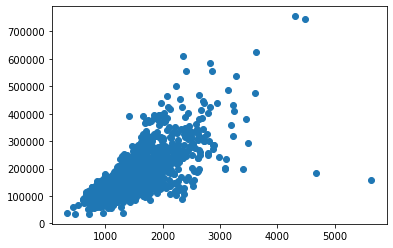

In [325]:
plt.scatter(train.GrLivArea, train.SalePrice) #above ground (grade) living area

In [326]:
train.GrLivArea.quantile(0.999999)

5640.590605999934

Comment: The plot maps of all features vs SalePrice has been examed. However, only the two outliers of GrLivArea are noticeably off the linear trend of the plot

In [327]:
# Deleting outliers
#Some domain knowledge here
train = train[train.GrLivArea < 4500] 
train.reset_index(drop=True, inplace=True) 

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the Saleprice column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

#Put train and test set to the same file
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape) #Note that 2 row has been dropped from test set

(2917, 79)


### Transform the data and fill na

In [328]:
#Function to check nan
def nan_(df):
    fool=df.isna().sum()
    count=0
    for i in df.columns:
        if fool[i]>0:
            print(i,fool[i])
            count+=1
    return count

In [329]:
#Function to check cat columns
def cat_object(df):
    return [col for col in df.columns if df[col].dtype=='O']

In [330]:
def feature_analysis(df,col):
    print("Unique values are:",df[col].unique())
    print("The mode is: ", df[col].mode()[0] )
    return df.groupby(col).agg(["mean","count","median"]).SalePrice

In [331]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [332]:
feature_analysis(train,'MSZoning')

Unique values are: ['RL' 'RM' 'C (all)' 'FV' 'RH']
The mode is:  RL


,mean,count,median
MSZoning,,,
C (all),11.118275,10,11.217680
FV,12.246621,65,12.235394
RH,11.749848,16,11.823758
RL,12.085945,1149,12.066816
RM,11.692901,218,11.699413


In [333]:
#Use feature_analysis function to see if you want to fill na with mode or mean.
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna("VinylSd")
features['Exterior2nd'] = features['Exterior2nd'].fillna("VinylSd")
features['SaleType'] = features['SaleType'].fillna("WD")

#Since the price of house with Pool have high correlation with SalePrice, you should keep this collumn
features["PoolQC"] = features["PoolQC"].fillna("None")

#Some domain knowledge here 
#MSSubClass: The building class
#MSZoning: The general zoning classification
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [334]:
features.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [335]:
feature_analysis(train,"BsmtExposure")

Unique values are: ['No' 'Gd' 'Mn' 'Av' nan]
The mode is:  No


,mean,count,median
BsmtExposure,,,
Av,12.158273,221,12.132701
Gd,12.369054,132,12.352172
Mn,12.094825,114,12.114139
No,11.955660,953,11.944714


In [336]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'): #Numerical values
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']: #Categorical values
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'): #Categorical values
    features[col] = features[col].fillna('None')

In [337]:
print(nan_(features))

LotFrontage 486
Alley 2719
Utilities 2
MasVnrType 24
MasVnrArea 23
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
FireplaceQu 1420
Fence 2346
MiscFeature 2812
14


In [338]:
#Remaining cat columns are filled with nan
objects = cat_object(features)

features.update(features[objects].fillna('None'))

#Domain knowledge here
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print("Number of nan left over",(features.isna().sum()>0).sum())

Number of nan left over 7


In [339]:
# Filling numerical columns with nan

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] #Avoid having different dtype
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

print("Number of nan left over",(features.isna().sum()>0).sum())

Number of nan left over 0


### Encoding

**Ordinal feature**

In [340]:
grade_map={"None":0,"Po":1, "Fa":2,"TA":3,"Gd":4,"Ex":5}
cols1=["ExterQual","ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond"]
for i in cols1:
    features[i]=features[i].map(grade_map)

exposure_map={"Gd":4,"Av":3,"Mn":2, "No":0, "NA":0,"None":0}
features["BsmtExposure"]=features["BsmtExposure"].map(exposure_map)

bsmt_map={"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1, "NA":0,"None":0}
cols2=["BsmtFinType1"]
for i in cols2:
    features[i]=features[i].map(bsmt_map)

garage_map={"Fin":3,"RFn":2,"Unf":1,"NA":0,"None":0}
features["GarageFinish"]=features["GarageFinish"].map(garage_map)


pavement_map={"Y":2,"P":1,"N":0,"None":0}
features["PavedDrive"]=features["PavedDrive"].map(pavement_map)

### Skewness
Taking care of skew features by Box-cox, a hybrid log1p piecewise function

**Skewness** 
Dealing with extreme long/short tails on both sides
* $(-0.5,0.5)$: symmetrical
* $(-1,-0.5)$ : moderatedly negative skew
* $(0.5,1)$: moderatedly positive skew
* More or less than that: highly skew

**Box-cox transformation**


\begin{cases} 
      \frac{((1+x)^\lambda - 1)}{\lambda} & \lambda \not= 0 \\
      log(1+x) & \lambda = 0 
\end{cases}

where $x$ is the data, and lambda is any real number that should be chosen so that the skewness level is minimal.

Code: `boxcox1p`

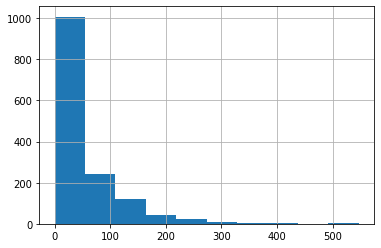

In [14]:
df.OpenPorchSF.hist(bins=10)

In [341]:
#Get the skewness level for each feature
numerics=[i for i in numerics if i not in ["OverallQual","OverallCond","YearBuilt","YearRemodAdd",]]
skew_features = features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
LotFrontage       1.103039
GrLivArea         1.068750
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
BedroomAbvGr      0.326568
GarageArea        0.216857
FullBath          0.165514
GarageCars       -0.219297
GarageYrBlt      -3.904632
dtype: float64

In [342]:
#Get the one that out of symetric range
#Dont touch feature with negative skew score
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

#Apply boxcox1p. Note that the second parameter is lambda. 
#Since we do not know lambda, we need to use boxcox_normax
#Add 1 since boxcox_normmax only accept the array of positive values (we have some 0 here)
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

### Combine some terms to reduce the data

In [343]:
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

### Simplify the feature

In [344]:
#It is a good idea to classified these columns since 0 is the mode of the column.

features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [345]:
#Get onehot the rest
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

(2917, 86)
(2917, 281)


In [346]:
#We stack up the train and test data before, now we split it back to its original state
#Note that we cannot modified any of the test set row. 
 
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1458, 281) y (1458,) X_sub (1459, 281)


### Remove outliers and overfit column

In [347]:
#Suggestion from Kaggle
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [434]:
#Throwing away columns that has more than 99.94% of 1-type dominant feature. 
#The decision comes from changing the percent values and checking the importance of 1-type dominant feature
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)
overfit

[]

In [349]:
#Commercial
X['MSZoning_C (all)'].value_counts() 

0    1445
1       8
Name: MSZoning_C (all), dtype: int64

In [350]:
#Kaggle suggestion
overfit = list(overfit)
overfit.append('MSZoning_C (all)') 

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1453, 279) y (1453,) X_sub (1459, 279)


In [351]:
(X_sub.isna().sum()).sum()

0

### Feature Importance

In [352]:
temp1=X.copy()
temp1["SalePrice"]=y

cols=temp1.columns
temp1[cols].corr()["SalePrice"].sort_values(ascending = False).head(10)

SalePrice          1.000000
OverallQual        0.824807
GrLivArea          0.741823
ExterQual          0.683785
GarageCars         0.683090
Total_Bathrooms    0.676898
KitchenQual        0.670858
GarageArea         0.658926
TotalBsmtSF        0.647537
YrBltAndRemod      0.645689
Name: SalePrice, dtype: float64

# MACHINE LEARNING

In [353]:
#METRIC
# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error",cv=5))
    return (rmse)


In [354]:
#cv grid search parameter
alphas_alt = [14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,0.0009]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,0.0008]
e_l1ratio = [0.8,0.83, 0.85, 0.9,0.93, 0.95, 0.99, 1]

In [355]:
# setup models  
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=5,))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=5))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=5, random_state=42, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


# gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(objective ='reg:squarederror',
                       learning_rate=0.01, n_estimators=3460,
                        max_depth=3, min_child_weight=0,
                        gamma=0, subsample=0.7,
                        colsample_bytree=0.7,
                        nthread=-1,
                        scale_pos_weight=1, seed=27,
                        reg_alpha=0.00006, random_state=42)

# stack
# stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,svr, lightgbm, xgboost),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)


# Score

In [356]:
score = cv_rmse(ridge)
print("Kernel Ridge score: {}, {}".format(score.mean(), score.std()))


score = cv_rmse(lasso)
print("Lasso score: {}, {}".format(score.mean(), score.std()))


score = cv_rmse(elasticnet)
print("ElasticNet score: {}, {}".format(score.mean(), score.std()))


score = cv_rmse(svr)
print("SVR score: {}, {}".format(score.mean(), score.std()))


score = cv_rmse(lightgbm)
print("Lightgbm score: {}, {}".format(score.mean(), score.std()))

Kernel Ridge score: 0.10544285360771415, 0.005048300572906406
Lasso score: 0.10521605226679225, 0.005072682434689962
ElasticNet score: 0.10525338262945771, 0.0050823825122055695
SVR score: 0.10340297956179482, 0.007471957210273739
Lightgbm score: 0.10880562321636571, 0.005214974032784027


In [357]:
score = cv_rmse(xgboost)
print("Xgboost score: {}, {}".format(score.mean(), score.std()))

Xgboost score: 0.10733977130698373, 0.004425408214616619


In [358]:
#Way too long
# score = cv_rmse(stack_gen)
# print("stack_gen score: {}, {}".format(score.mean(), score.std()))

In [359]:
#Remove this since it cause error
# score = cv_rmse(gbr)
# print("GradientBoosting score: {}, {}".format(score.mean(), score.std()))

### Blend Model

The weights are based on the performance

In [360]:
#Fitting

# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
start=time.time()
print(0.00, 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print(round(time.time()-start,2), 'lasso')
lasso_model_full_data = lasso.fit(X, y)

print(round(time.time()-start,2), 'ridge')
ridge_model_full_data = ridge.fit(X, y)

print(round(time.time()-start,2), 'svr')
svr_model_full_data = svr.fit(X, y)

# print(datetime.now(), 'GradientBoosting')
# gbr_model_full_data = gbr.fit(X, y)

print(round(time.time()-start,2), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print(round(time.time()-start,2), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

0.0 elasticnet
1.86 lasso
2.28 ridge
2.74 svr
3.53 xgboost
46.53 lightgbm


In [454]:
#Model stacking

def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X))  
            +(0.1 * lasso_model_full_data.predict(X)) 
            +(0.2 * ridge_model_full_data.predict(X)) 
            +(0.2 * svr_model_full_data.predict(X)) 
            +(0.2 * xgb_model_full_data.predict(X)) 
            +(0.2 * lgb_model_full_data.predict(X))
           )

In [455]:
#0.08260985813438536
#0.0805465841490437
#0.07481781181991821 xgb 0.3
#0.059904333000129165
#0.04817098148846413 only xgb
print('Blend model score on train data:')
log_y_pred=blend_models_predict(X)
log_y = y
np.sqrt(np.sum(np.square(log_y-log_y_pred))/len(y))

Blend model score on train data:


0.072013608551831

In [456]:
#r2 score
r2_score(np.expm1(y),np.expm1(blend_models_predict(X)))

0.9698922212082541

In [457]:
log_y_pred=xgb_model_full_data.predict(X)
log_y = y
np.sqrt(np.sum(np.square(log_y-log_y_pred))/len(y))

0.04698311318463183

# Submission

In [458]:
len(ID_test)

1459

In [459]:
len(X_sub)

1459

In [460]:
price=np.expm1(blend_models_predict(X_sub))

In [461]:
submission=pd.DataFrame({"Id":ID_test,"SalePrice":price})

In [462]:
# # Brutal approach to deal with predictions close to outer range 
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.75)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.15)

In [463]:
!ls Submission

sub.csv


In [464]:
!rm Submission/sub.csv
submission.to_csv("Submission/sub.csv", index = False)

In [385]:
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.144572,13.833054,7,5,2003,2003,19.433172,4,3,4,...,0,0,0,1,0,0,0,0,1,0
1,20.673624,14.117918,6,8,1976,1976,0.000000,3,3,4,...,0,0,0,1,0,0,0,0,1,0
2,18.668046,14.476513,7,5,2001,2002,17.768838,4,3,4,...,0,0,0,1,0,0,0,0,1,0
3,17.249650,14.106197,7,5,1915,1970,0.000000,3,3,3,...,0,0,0,1,1,0,0,0,0,0
4,21.314282,15.022008,8,5,2000,2000,25.404161,4,3,4,...,0,0,0,1,0,0,0,0,1,0
